# Sample processing of k-mer feature extraction and dimensionality reduction

This notebook attempts to show the reproducibility of our research by extracting the 3mc feature from a subsample of roughly 329,294 SARS-CoV-2 sequences.

In [135]:
# Loading of relevant modules:
from os import listdir
from os.path import join
import pacmap
from Bio import SeqIO 
import classix 
import hdbscan 

# Loading of tools for preprocessing, qualitative evaluation and plotting:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import NullFormatter
import matplotlib.lines as mlines
from natsort import natsorted

# Feature extraction scripts
from NVs import *

# Activation of inline plotting
%matplotlib inline

1. listing of fasta files to be processed:

In [12]:
in_folder = './GISAID_Subsample'
files =  [file for file in listdir(in_folder)]
files

['GISAID_SARSCOV2_file000.fasta',
 'GISAID_SARSCOV2_file001.fasta',
 'GISAID_SARSCOV2_file002.fasta',
 'GISAID_SARSCOV2_file003.fasta',
 'GISAID_SARSCOV2_file004.fasta',
 'GISAID_SARSCOV2_file005.fasta',
 'GISAID_SARSCOV2_file006.fasta',
 'GISAID_SARSCOV2_file007.fasta',
 'GISAID_SARSCOV2_file008.fasta',
 'GISAID_SARSCOV2_file009.fasta',
 'GISAID_SARSCOV2_file010.fasta',
 'GISAID_SARSCOV2_file011.fasta',
 'GISAID_SARSCOV2_file012.fasta',
 'GISAID_SARSCOV2_file013.fasta',
 'GISAID_SARSCOV2_file014.fasta',
 'GISAID_SARSCOV2_file015.fasta',
 'GISAID_SARSCOV2_file016.fasta',
 'GISAID_SARSCOV2_file017.fasta',
 'GISAID_SARSCOV2_file018.fasta',
 'GISAID_SARSCOV2_file019.fasta',
 'GISAID_SARSCOV2_file020.fasta',
 'GISAID_SARSCOV2_file021.fasta',
 'GISAID_SARSCOV2_file022.fasta',
 'GISAID_SARSCOV2_file023.fasta',
 'GISAID_SARSCOV2_file024.fasta',
 'GISAID_SARSCOV2_file025.fasta',
 'GISAID_SARSCOV2_file026.fasta',
 'GISAID_SARSCOV2_file027.fasta',
 'GISAID_SARSCOV2_file028.fasta',
 'GISAID_SARSC

2. Preprocessing of the sequences to $3mc$ feature and consolidation in a single DataFrame

In [37]:
# Dataframe to consolidate the extracted features
# from all the sequences
kmc = pd.DataFrame()

# Loop to extract the taxon, scorpio label
# and genetic sequence.
for file in files:
    records = SeqIO.parse(join(in_folder, 
                               file,
                              ),
                          'fasta',
                         )
    for record in records:
        taxonNlabel = record.id.split('|')
        sequence = ''.join(record.seq)
        feature = KMC(sequence, k=3)
        columns = (['taxon', 'label']
                   +list(feature.keys())
                  )
        data = (taxonNlabel
                +list(feature.values())
               )
        df = pd.DataFrame(columns=columns, 
                          data=[data],
                         )
        kmc = pd.concat([kmc, df], 
                        ignore_index=True,
                       )

3. Retrival, normalisation, formating of data (X) and labels (y) and dimensionality reduction through PaCMAP

In [194]:
# Retriving data from the consolidated dataframe
X = kmc.iloc[:, 2:]
y = kmc.iloc[:, 1].values.T

# Normalisation of the input data
X = MinMaxScaler().fit_transform(X)

# Due to a bug on the PaCMAP code the default of NN
# is set to 10, regardles teh size of the input data.
# This script solves that
nn = max(10, int(np.round(10
                          + 15 
                          * (np
                             .log10(X.shape[0]
                                   )
                             - 4
                            ),
                          0
                         )
                )
        )


# For the whole dataset the parameters MN_ratio
# and FP_ratio, were set to 1.0, but with with 
# small volumes the default settings seem to work
# better
PaCMAPParams = dict(n_components=3, 
                    n_neighbors=nn, 
                    random_state=13,
               )
embedding = pacmap.PaCMAP(**PaCMAPParams)
X_PaCMAP = embedding.fit_transform(X).T

# This line normalise the resulting PaCMAP projection
# and centers it on coordinates (0,0,0)
X_PaCMAP2 = MinMaxScaler().fit_transform(X_PaCMAP.T).T-0.5

C:\Users\v95983rc\.conda\envs\DimRedCovid19\lib\site-packages\pacmap\pacmap.py:774: UserWarning: Warning: random state is set to 13
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


4. Clustering processes and qualitative evaluation by Adjusted Rand and Adjusted Mutual Information scores

In [197]:
# Setting up the parameters of HDBSCAN
hd = (hdbscan
      .HDBSCAN(min_samples=5, 
               min_cluster_size=500,
              )
     )
# Finding clusters through HDBSCAN
hdbscan_labels = (hd
                  .fit_predict(X_PaCMAP2
                               .T
                              )
                 )
# Evaluating HDBSCAN clusters
(hdbscan_rand,
 hdbscan_mutual,
) = (adjusted_rand_score(y,
                         hdbscan_labels,
                        ), 
     adjusted_mutual_info_score(y, 
                                hdbscan_labels,
                               )
    )

# Setting up the parameters of CLASSIX
cl = (classix
      .CLASSIX(verbose=0,
               radius=0.2, 
               minPts=500, 
              )
     )
# Finding clusters through CLASSIX
classix_labels = (cl
                  .fit_transform(X_PaCMAP2
                                 .T
                                )
                 )
# Evaluating CLASSIX clusters
(classix_rand,
 classix_mutual,
) = (adjusted_rand_score(y, 
                         classix_labels,
                        ), 
     adjusted_mutual_info_score(y,
                                classix_labels,
                               )
    )

C:\Users\v95983rc\.conda\envs\DimRedCovid19\lib\site-packages\classix\clustering.py:451: UserWarning: This CLASSIX installation is not using Cython.
  warnings.warn("This CLASSIX installation is not using Cython.")


5. Plotting of results.

In [ ]:
# Customising cmap "jet_r" to have darker colours
newcolors = mpl.cm.jet_r(np.linspace(0,1,256))
newcolors = np.array([[ch*0.75 for ch in v[:-1]] 
                      for v in newcolors
                     ]
                    )
newjet = mpl.colors.ListedColormap(newcolors)

# Setting up the labels to get a consistent
# colour code based on phylogenetic similitud
scorpio_labels = LabelEncoder().fit_transform(y)
clusterings = {'scorpio': [scorpio_labels, 
                           1.0, 
                           1.0,
                          ],
               'hdbscan': [hdbscan_labels, 
                           hdbscan_rand, 
                           hdbscan_mutual,
                          ],
               'classix': [classix_labels,
                           classix_rand,
                           classix_mutual,
                          ]
              }
# Dictionaries and lists to process extended 
# labels
dict_labels = dict(zip(scorpio_labels, y))
dict_labels_r = dict(zip(y, scorpio_labels))
scorpio_classes = list(set(y))
lineage_equivalents = {'BA.': 'B.1.1.529.',
                       'C.': 'B.1.1.1.',
                       'P.': 'B.1.1.28.',
                       'AY.': 'B.1.617.2.',
                       'XE': 'B.1.1.529.1&2',
                      }
dict_translator = {lin:(lin.replace(k, v) if k in lin else lin)
                   for k, v in lineage_equivalents.items()
                   for lin in scorpio_classes 
                   if k in lin
                  }
dict_translator = {v:(dict_translator[v] 
                      if v in dict_translator.keys() 
                      else v
                     )for v in scorpio_classes
                  }
dict_translator_r = {v:k for k, v in dict_translator.items()}

# Sorting extended labels to create a colour code
# reflecting phylogenetic proximity
long_lineages = natsorted(dict_translator.values())
dict_colours = {dict_translator_r[k]:newjet(i/len(long_lineages)) 
                for i, k in enumerate(long_lineages)
               }
dict_colours['Unassigned'] = (0.5,0.5,0.5,1.0)

# Mapping of the scorpio labels to apply colour code
scorpio_colours = [dict_colours[y0] for y0 in y]

C:\Users\v95983rc\AppData\Local\Temp\ipykernel_20928\4149292500.py:90: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(*X_PaCMAP2,


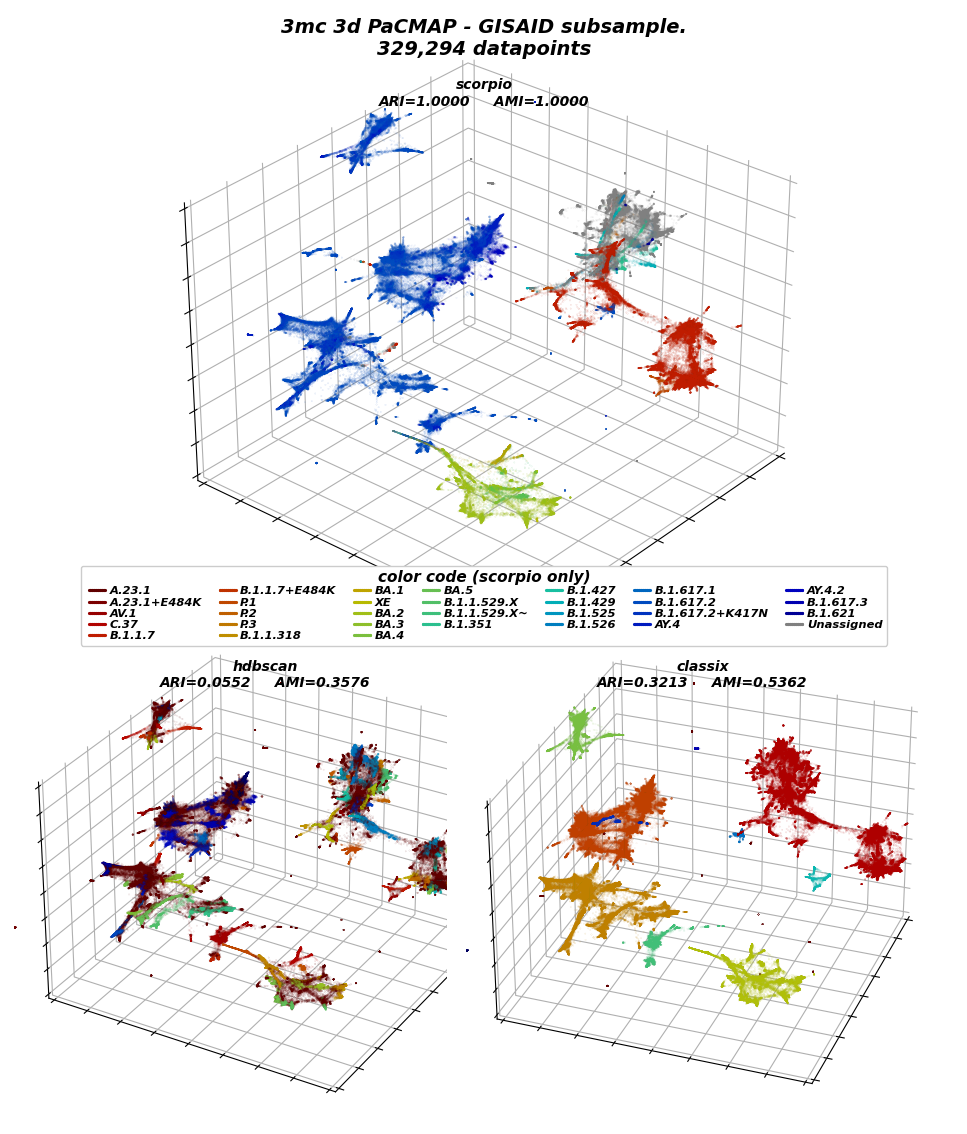

In [198]:
# Defining the layout of the figure
mosaic = '''
         .AAA.
         .AAA.
         .AAA.
         .....
         BB.CC
         BB.CC
         '''
fig, axs = plt.subplot_mosaic(mosaic, 
                              constrained_layout=True,
                              figsize=[18,12],
                              subplot_kw={'projection':'3d'},
                             )
# Customising background colour and title
N = len(y)
fig.set_facecolor([0.0]*4)
fig.suptitle(('3mc '
              '3d PaCMAP - '
              'GISAID subsample.\n'
              f'{N:,.0f} '
              'datapoints'
             ),
             x=0.5, 
             y=0.90, 
             ha='center', 
             va='bottom', 
             transform=fig.transFigure,
             fontsize=14,
            )

# Plotting of same projection with different
# labelling: Scorpio, HDBSCAN or CLASSIX
for i, (classification, 
        (labels, rand, mutual)
       ) in enumerate(clusterings.items(),
                      1,
                     ):
    ax = fig.axes[i-1]
    c = labels if classification!='scorpio' else scorpio_colours
    scatter = ax.scatter(*X_PaCMAP2, 
               c=c,
               s=0.005, 
               depthshade=True, 
               rasterized=True, 
               cmap=newjet,
              )
    # Setting title of the subplot
    ax.set_title((f'{classification}\n'
                  f'ARI={rand:.4f}'
                  '     '
                  f'AMI={mutual:.4f}'
                 ),
                 x=0.5, 
                 y=0.925, 
                 ha='center', 
                 va='bottom', 
                 transform=ax.transAxes, 
                 fontsize=10,
                )
    # Dynamic camera angles
    elev, azim = [30]*2
    azim = azim-(i-2)*10
    ax.view_init(elev=elev, 
                 azim=azim,
                )
    lim = 0.4
    # Cleaning the axis of ticks and tick-labels.
    # Since it is a projection they are not 
    # meaningful
    for a in ['x','y','z']:
        eval(('ax'
              f'.set_{a}lim(-lim,lim)'
             )
            )
        eval(('ax'
              f'.{a}axis'
              '.set_major_formatter(NullFormatter())'
             )
            )    
        eval(('ax'
              f'.{a}axis'
              '.set_pane_color([1.]*4)'
             )
            )

# Creating legend explaining the colour code,
# which is only applicaple to Scorpio
label_classes = list(set(y))
handles = []
for l in label_classes:
    handle = mlines.Line2D([], [], 
                           color=dict_colours[l], 
                           marker='.', 
                           linestyle='none', 
                           markersize=5,
                           label=l, 
                          )
    handles.append(handle)
        
handles = natsorted(handles,
                    key=lambda x: dict_translator[x.get_label()]
                   )


labs = [h.get_label() for h in handles]
bbox_y = 0.98 
fig.legend(handles, 
           labs, 
           title='color code (scorpio only)',
           title_fontsize=11,
           bbox_to_anchor=(0.5, 0.4825), 
           bbox_transform=fig.transFigure, 
           markerscale=0.5,
           loc='upper center', 
           numpoints=25, 
           ncol=7, 
           fontsize=8.25,
           handletextpad=0.1, 
           columnspacing=1.25, 
           frameon=True, 
           labelspacing=0.1, 
           framealpha=1.0,
          )

# Final adjustments of subplots
fig.tight_layout(h_pad=-15, 
                 w_pad=-75,
                )